ref: [here](https://github.com/kashish45/Text-Generation-Using-Tensorflow/blob/master/Untitled44.ipynb)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [ ]:
text = "In the town of Athy one Jeremy Lanigan \\n Battered away til he hadnt a pound. \\nHis father died and made him a man again \\n Left him a farm and ten acres of ground. \\nHe gave a grand party for friends and relations \\nWho didnt forget him when come to the wall, \\nAnd if youll but listen Ill make your eyes glisten \\nOf the rows and the ructions of Lanigans Ball. \\nMyself to be sure got free invitation, \\nFor all the nice girls and boys I might ask, \\nAnd just in a minute both friends and relations \\nWere dancing round merry as bees round a cask. \\nJudy ODaly, that nice little milliner, \\nShe tipped me a wink for to give her a call, \\nAnd I soon arrived with Peggy McGilligan \\nJust in time for Lanigans Ball. \\nThere were lashings of punch and wine for the ladies, \\nPotatoes and cakes; there was bacon and tea, \\nThere were the Nolans, Dolans, OGradys \\nCourting the girls and dancing away. \\nSongs they went round as plenty as water, \\nThe harp that once sounded in Taras old hall,\\nSweet Nelly Gray and The Rat Catchers Daughter,\\nAll singing together at Lanigans Ball. \\nThey were doing all kinds of nonsensical polkas \\nAll round the room in a whirligig. \\nJulia and I, we banished their nonsense \\nAnd tipped them the twist of a reel and a jig. \\nAch mavrone, how the girls got all mad at me \\nDanced til youd think the ceiling would fall. \\nFor I spent three weeks at Brooks Academy \\nLearning new steps for Lanigans Ball. \\nThree long weeks I spent up in Dublin, \\nThree long weeks to learn nothing at all,\\n Three long weeks I spent up in Dublin, \\nLearning new steps for Lanigans Ball. \\nShe stepped out and I stepped in again, \\nI stepped out and she stepped in again, \\nShe stepped out and I stepped in again, \\nLearning new steps for Lanigans Ball. \\nBoys were all merry and the girls they were hearty \\nAnd danced all around in couples and groups, \\nTil an accident happened, young Terrance McCarthy \\nPut his right leg through miss Finnertys hoops. \\nPoor creature fainted and cried Meelia murther, \\nCalled for her brothers and gathered them all. \\nCarmody swore that hed go no further \\nTil he had satisfaction at Lanigans Ball. \\nIn the midst of the row miss Kerrigan fainted, \\nHer cheeks at the same time as red as a rose. \\nSome of the lads declared she was painted, \\nShe took a small drop too much, I suppose. \\nHer sweetheart, Ned Morgan, so powerful and able, \\nWhen he saw his fair colleen stretched out by the wall, \\nTore the left leg from under the table \\nAnd smashed all the Chaneys at Lanigans Ball. \\nBoys, oh boys, twas then there were runctions. \\nMyself got a lick from big Phelim McHugh. \\nI soon replied to his introduction \\nAnd kicked up a terrible hullabaloo. \\nOld Casey, the piper, was near being strangled. \\nThey squeezed up his pipes, bellows, chanters and all. \\nThe girls, in their ribbons, they got all entangled \\nAnd that put an end to Lanigans Ball."

In [ ]:
corpus = text.lower().split("\\n")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [ ]:
input_seq = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    ngram_seq = token_list[:i+1]
    input_seq.append(ngram_seq)

In [ ]:
max_seq_len = max([len(x) for x in input_seq])
input_seq = np.array(pad_sequences(input_seq, maxlen=max_seq_len, padding='pre'))

X, y = input_seq[:, :-1], input_seq[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

In [ ]:
model = Sequential([
    Embedding(total_words, 64, input_length=max_seq_len - 1),
    Bidirectional(LSTM(20)),
    Dense(total_words, activation='softmax'),
])
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X, y, epochs=500)

Epoch 1/500
15/15 [==============================] - 5s 89ms/step - loss: 5.5688 - accuracy: 0.0221
Epoch 2/500
15/15 [==============================] - 1s 50ms/step - loss: 5.5436 - accuracy: 0.0508
Epoch 3/500
15/15 [==============================] - 0s 29ms/step - loss: 5.4830 - accuracy: 0.0508
Epoch 4/500
15/15 [==============================] - 1s 35ms/step - loss: 5.3133 - accuracy: 0.0508
Epoch 5/500
15/15 [==============================] - 1s 52ms/step - loss: 5.1357 - accuracy: 0.0508
Epoch 6/500
15/15 [==============================] - 0s 10ms/step - loss: 5.0710 - accuracy: 0.0508
Epoch 7/500
15/15 [==============================] - 1s 57ms/step - loss: 5.0399 - accuracy: 0.0552
Epoch 8/500
15/15 [==============================] - 0s 29ms/step - loss: 5.0141 - accuracy: 0.0486
Epoch 9/500
15/15 [==============================] - 0s 22ms/step - loss: 4.9850 - accuracy: 0.0508
Epoch 10/500
15/15 [==============================] - 0s 22ms/step - loss: 4.9500 - accuracy: 0.0552

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

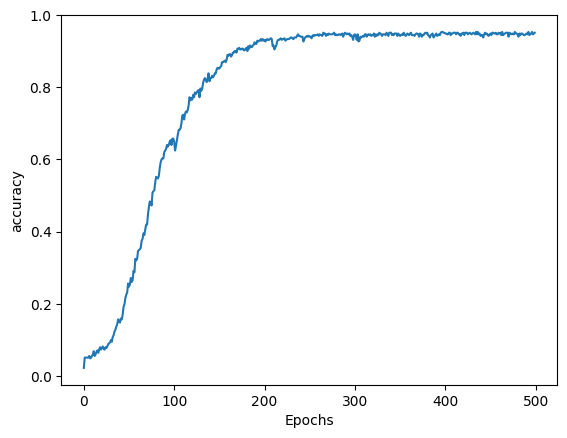

In [ ]:
plot_graphs(history, "accuracy")

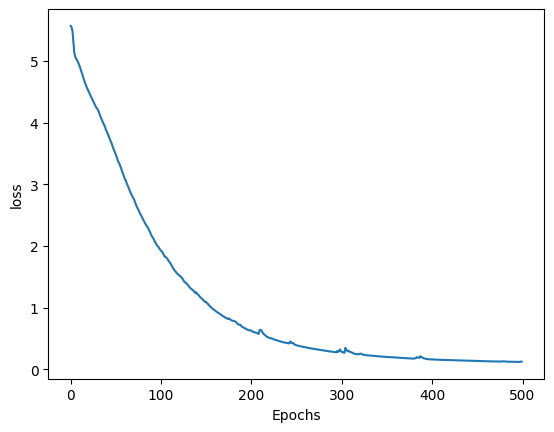

In [ ]:
plot_graphs(history, "loss")

In [ ]:
seed_text = "Laurence went to dublin"
next_words = 20

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_seq_len - 1, padding='pre')
  predicted = model.predict(token_list, verbose=0)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == np.argmax(predicted, axis=1):
      output_word = word
      break
  seed_text += " " + output_word

seed_text

'Laurence went to dublin round red as as plenty as water water glisten round rose cask cask cask dublin round glisten glisten gave round'